# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hnc_Ng import  HNC_solver
from qsps import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
        
        
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Function that sets up HNC QSP 

In [24]:
def set_hnc(n_in_per_cc, T, Z, A, Zstar, c_k_guess=None , which_Tij='thermal',
            oz_type='standard', method='kryov', add_bridge=False, bridge='yukawa',
            pseudopotential=False, r_c=0.6, no_coupling=False):
    
    n_in_AU = n_in_per_cc*1e6 *aB**3
    ri = QSP_HNC.rs_from_n(n_in_AU)
    qsp = QSP_HNC(Z, A, Zstar, T, T, ri, Zstar*n_in_AU, which_Tij=which_Tij, r_c=r_c)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = np.array([qsp.Ti, qsp.Te_c])
    masses= np.array([qsp.m_i, m_e])
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses ,
                     kappa_multiscale=5, R_max=R_max, N_bins=N_bins, 
                      names=names, dst_type=3, oz_method=oz_type)

    if pseudopotential==True:
        βvei = qsp.βvei_atomic(hnc1.r_array)
    else:
        βvei = qsp.βvei(hnc1.r_array)
    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), βvei],
                            [βvei, qsp.βvee(hnc1.r_array)]])
    if no_coupling:
        βu_r_matrix[0,1]=0
        βu_r_matrix[1,0]=0
    
    if add_bridge:
        if bridge=='ocp':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_OCP(hnc1.r_array, qsp.Γii)
        elif bridge=='yukawa':
            βu_r_matrix[0,0] = βu_r_matrix[0,0] - hnc1.Bridge_function_Yukawa(hnc1.r_array, qsp.Γii, qsp.get_κ())
    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()

    return hnc1, qsp

## Load TCCW Cases

In [25]:
mixture_file = "/home/zach/plasma/hnc/data/TCCW_single_species_data.csv"
tccw_mixture_data = read_csv(mixture_file)
tccw_cases = [tccw_mixture_data.iloc[n] for n in range(len(tccw_mixture_data))]

case_successes = {}
SVT_case_successes = {}
R_max = 10
N_bins = 1000
max_attempts=1

tccw_case = tccw_cases[3]
α = 0.1
case_converged=False
case_attempts=0
case_num= tccw_case[' ']
case_id = tccw_case['Case ID']
ni = tccw_case['Number Density [N/cc]']
Te = tccw_case['Temperature [eV]']*eV
Ti = Te
Z = tccw_case['Atomic Number']
Zstar = tccw_case['Zbar (TFDW)']
A = tccw_case['Atomic Weight [a.u.]']
r_s = tccw_case['Wigner-Seitz Radius [cm]']
r_c = tccw_case['Average-Bound Radius [cm]']/r_s

print('\n______________________________\nCase num: {0} Case ID: {1}'.format(case_num, case_id))
print("Te = {0:.3e} eV, n_i = {1:.3e} 1/cc, r_c/r_s = {2:.3f}".format(Te/eV, ni, r_c))



______________________________
Case num: 3 Case ID: Cu1
Te = 1.000e+00 eV, n_i = 8.490e+22 1/cc, r_c/r_s = 0.198


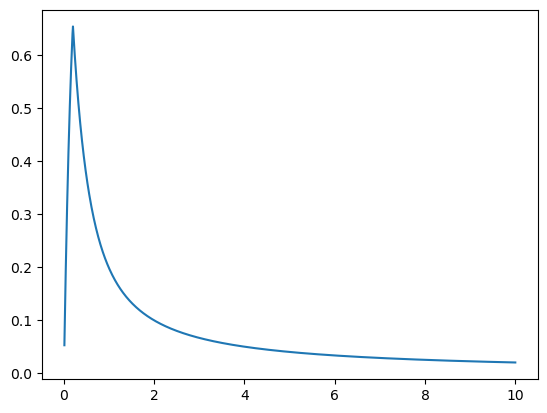

In [31]:
fig, ax = plt.subplots()

ax.plot(atom.r_array, atomqsp.βvei_atomic(atom.r_array))

# Make atom

In [27]:
atom, atomqsp = set_hnc(ni, Te, Z, A, Zstar, 
                            pseudopotential=True, oz_type='svt',r_c=r_c, 
                            add_bridge=True, bridge='ocp')

atom.HNC_solve(alpha_method='fixed', alpha_Picard = 0.5, tol=1e-3, alpha_Ng=1e-10, 
               iters_to_wait=1e4, num_iterations=1e3)
atom.HNC_newton_solve(method='krylov', rdiff=1e-8, num_iterations=5e2, tol=1e-6)


Λei = 0.186
Λee = 0.263
Λei adjusted with R = 0.186
Γii=301.565, Γie=-3.156, Γee=0.580 
r_i=2.667
r_e=1.517
r_c=0.198
θ  =4.59e-02
0: Change in c_r: 2.840e-01, HNC Error: 9.348e-03, Total Error: 2.437e+02
1: Change in c_r: 2.670e-01, HNC Error: 1.629e-01, Total Error: 1.524e+02
2: Change in c_r: 2.554e-01, HNC Error: 1.245e+06, Total Error: 9.690e+01
3: Change in c_r: 2.578e-01, HNC Error: 7.882e+00, Total Error: 6.353e+01
4: Change in c_r: 2.431e-01, HNC Error: 9.528e+40, Total Error: 4.355e+01
5: Change in c_r: 3.252e-01, HNC Error: 1.566e-02, Total Error: 3.083e+01
6: Change in c_r: 2.153e-01, HNC Error: 1.231e-01, Total Error: 2.372e+01
7: Change in c_r: 2.158e-01, HNC Error: 5.529e+139, Total Error: 2.079e+01
8: Change in c_r: 7.009e-01, HNC Error: 7.716e+55, Total Error: 1.262e+01
9: Change in c_r: 7.318e-01, HNC Error: 3.705e+08, Total Error: 1.194e+01
10: Change in c_r: 3.590e-01, HNC Error: 2.313e-02, Total Error: 1.350e+01
11: Change in c_r: 1.759e-01, HNC Error: 1.420e-02, T

109: Change in c_r: 1.133e-01, HNC Error: 2.649e-02, Total Error: 4.179e-01
110: Change in c_r: 1.124e-01, HNC Error: 2.564e-02, Total Error: 4.102e-01
111: Change in c_r: 1.115e-01, HNC Error: 2.482e-02, Total Error: 4.027e-01
112: Change in c_r: 1.107e-01, HNC Error: 2.404e-02, Total Error: 3.953e-01
113: Change in c_r: 1.098e-01, HNC Error: 2.327e-02, Total Error: 3.880e-01
114: Change in c_r: 1.090e-01, HNC Error: 2.254e-02, Total Error: 3.810e-01
115: Change in c_r: 1.081e-01, HNC Error: 2.183e-02, Total Error: 3.740e-01
116: Change in c_r: 1.073e-01, HNC Error: 2.115e-02, Total Error: 3.672e-01
117: Change in c_r: 1.064e-01, HNC Error: 2.049e-02, Total Error: 3.606e-01
118: Change in c_r: 1.056e-01, HNC Error: 1.985e-02, Total Error: 3.541e-01
119: Change in c_r: 1.048e-01, HNC Error: 1.924e-02, Total Error: 3.478e-01
120: Change in c_r: 1.040e-01, HNC Error: 1.865e-02, Total Error: 3.416e-01
121: Change in c_r: 1.032e-01, HNC Error: 1.808e-02, Total Error: 3.355e-01
122: Change 

217: Change in c_r: 5.054e-02, HNC Error: 3.361e-03, Total Error: 1.096e-01
218: Change in c_r: 5.021e-02, HNC Error: 3.333e-03, Total Error: 1.088e-01
219: Change in c_r: 4.989e-02, HNC Error: 3.305e-03, Total Error: 1.079e-01
220: Change in c_r: 4.957e-02, HNC Error: 3.277e-03, Total Error: 1.071e-01
221: Change in c_r: 4.926e-02, HNC Error: 3.250e-03, Total Error: 1.062e-01
222: Change in c_r: 4.895e-02, HNC Error: 3.224e-03, Total Error: 1.054e-01
223: Change in c_r: 4.864e-02, HNC Error: 3.198e-03, Total Error: 1.046e-01
224: Change in c_r: 4.834e-02, HNC Error: 3.172e-03, Total Error: 1.038e-01
225: Change in c_r: 4.805e-02, HNC Error: 3.147e-03, Total Error: 1.029e-01
226: Change in c_r: 4.775e-02, HNC Error: 3.122e-03, Total Error: 1.022e-01
227: Change in c_r: 4.746e-02, HNC Error: 3.097e-03, Total Error: 1.014e-01
228: Change in c_r: 4.717e-02, HNC Error: 3.073e-03, Total Error: 1.006e-01
229: Change in c_r: 4.689e-02, HNC Error: 3.049e-03, Total Error: 9.980e-02
230: Change 

325: Change in c_r: 2.790e-02, HNC Error: 1.420e-03, Total Error: 5.391e-02
326: Change in c_r: 2.775e-02, HNC Error: 1.411e-03, Total Error: 5.362e-02
327: Change in c_r: 2.761e-02, HNC Error: 1.402e-03, Total Error: 5.333e-02
328: Change in c_r: 2.746e-02, HNC Error: 1.393e-03, Total Error: 5.305e-02
329: Change in c_r: 2.732e-02, HNC Error: 1.385e-03, Total Error: 5.276e-02
330: Change in c_r: 2.718e-02, HNC Error: 1.376e-03, Total Error: 5.248e-02
331: Change in c_r: 2.704e-02, HNC Error: 1.368e-03, Total Error: 5.220e-02
332: Change in c_r: 2.689e-02, HNC Error: 1.359e-03, Total Error: 5.192e-02
333: Change in c_r: 2.675e-02, HNC Error: 1.351e-03, Total Error: 5.164e-02
334: Change in c_r: 2.661e-02, HNC Error: 1.343e-03, Total Error: 5.136e-02
335: Change in c_r: 2.647e-02, HNC Error: 1.335e-03, Total Error: 5.109e-02
336: Change in c_r: 2.634e-02, HNC Error: 1.327e-03, Total Error: 5.082e-02
337: Change in c_r: 2.620e-02, HNC Error: 1.320e-03, Total Error: 5.055e-02
338: Change 

433: Change in c_r: 1.593e-02, HNC Error: 8.298e-04, Total Error: 3.002e-02
434: Change in c_r: 1.585e-02, HNC Error: 8.258e-04, Total Error: 2.985e-02
435: Change in c_r: 1.577e-02, HNC Error: 8.219e-04, Total Error: 2.969e-02
436: Change in c_r: 1.569e-02, HNC Error: 8.179e-04, Total Error: 2.952e-02
437: Change in c_r: 1.561e-02, HNC Error: 8.140e-04, Total Error: 2.936e-02
438: Change in c_r: 1.553e-02, HNC Error: 8.101e-04, Total Error: 2.919e-02
439: Change in c_r: 1.545e-02, HNC Error: 8.062e-04, Total Error: 2.903e-02
440: Change in c_r: 1.537e-02, HNC Error: 8.023e-04, Total Error: 2.887e-02
441: Change in c_r: 1.529e-02, HNC Error: 7.984e-04, Total Error: 2.871e-02
442: Change in c_r: 1.521e-02, HNC Error: 7.945e-04, Total Error: 2.855e-02
443: Change in c_r: 1.513e-02, HNC Error: 7.907e-04, Total Error: 2.839e-02
444: Change in c_r: 1.506e-02, HNC Error: 7.868e-04, Total Error: 2.823e-02
445: Change in c_r: 1.498e-02, HNC Error: 7.829e-04, Total Error: 2.807e-02
446: Change 

541: Change in c_r: 9.170e-03, HNC Error: 4.663e-04, Total Error: 1.642e-02
542: Change in c_r: 9.123e-03, HNC Error: 4.637e-04, Total Error: 1.633e-02
543: Change in c_r: 9.077e-03, HNC Error: 4.610e-04, Total Error: 1.624e-02
544: Change in c_r: 9.031e-03, HNC Error: 4.584e-04, Total Error: 1.615e-02
545: Change in c_r: 8.986e-03, HNC Error: 4.558e-04, Total Error: 1.607e-02
546: Change in c_r: 8.940e-03, HNC Error: 4.532e-04, Total Error: 1.598e-02
547: Change in c_r: 8.895e-03, HNC Error: 4.507e-04, Total Error: 1.589e-02
548: Change in c_r: 8.850e-03, HNC Error: 4.481e-04, Total Error: 1.581e-02
549: Change in c_r: 8.806e-03, HNC Error: 4.456e-04, Total Error: 1.572e-02
550: Change in c_r: 8.761e-03, HNC Error: 4.430e-04, Total Error: 1.563e-02
551: Change in c_r: 8.717e-03, HNC Error: 4.405e-04, Total Error: 1.555e-02
552: Change in c_r: 8.673e-03, HNC Error: 4.380e-04, Total Error: 1.547e-02
553: Change in c_r: 8.629e-03, HNC Error: 4.356e-04, Total Error: 1.538e-02
554: Change 

649: Change in c_r: 5.353e-03, HNC Error: 2.546e-04, Total Error: 9.297e-03
650: Change in c_r: 5.327e-03, HNC Error: 2.532e-04, Total Error: 9.249e-03
651: Change in c_r: 5.301e-03, HNC Error: 2.518e-04, Total Error: 9.203e-03
652: Change in c_r: 5.275e-03, HNC Error: 2.504e-04, Total Error: 9.156e-03
653: Change in c_r: 5.250e-03, HNC Error: 2.491e-04, Total Error: 9.110e-03
654: Change in c_r: 5.224e-03, HNC Error: 2.477e-04, Total Error: 9.064e-03
655: Change in c_r: 5.199e-03, HNC Error: 2.464e-04, Total Error: 9.018e-03
656: Change in c_r: 5.173e-03, HNC Error: 2.451e-04, Total Error: 8.973e-03
657: Change in c_r: 5.148e-03, HNC Error: 2.437e-04, Total Error: 8.927e-03
658: Change in c_r: 5.123e-03, HNC Error: 2.424e-04, Total Error: 8.882e-03
659: Change in c_r: 5.098e-03, HNC Error: 2.411e-04, Total Error: 8.838e-03
660: Change in c_r: 5.074e-03, HNC Error: 2.398e-04, Total Error: 8.793e-03
661: Change in c_r: 5.049e-03, HNC Error: 2.385e-04, Total Error: 8.749e-03
662: Change 

757: Change in c_r: 3.187e-03, HNC Error: 1.444e-04, Total Error: 5.457e-03
758: Change in c_r: 3.172e-03, HNC Error: 1.437e-04, Total Error: 5.431e-03
759: Change in c_r: 3.157e-03, HNC Error: 1.430e-04, Total Error: 5.405e-03
760: Change in c_r: 3.142e-03, HNC Error: 1.423e-04, Total Error: 5.379e-03
761: Change in c_r: 3.127e-03, HNC Error: 1.415e-04, Total Error: 5.353e-03
762: Change in c_r: 3.112e-03, HNC Error: 1.408e-04, Total Error: 5.328e-03
763: Change in c_r: 3.098e-03, HNC Error: 1.401e-04, Total Error: 5.302e-03
764: Change in c_r: 3.083e-03, HNC Error: 1.394e-04, Total Error: 5.277e-03
765: Change in c_r: 3.068e-03, HNC Error: 1.387e-04, Total Error: 5.252e-03
766: Change in c_r: 3.054e-03, HNC Error: 1.380e-04, Total Error: 5.226e-03
767: Change in c_r: 3.040e-03, HNC Error: 1.373e-04, Total Error: 5.201e-03
768: Change in c_r: 3.025e-03, HNC Error: 1.366e-04, Total Error: 5.177e-03
769: Change in c_r: 3.011e-03, HNC Error: 1.359e-04, Total Error: 5.152e-03
770: Change 

865: Change in c_r: 1.925e-03, HNC Error: 8.479e-05, Total Error: 3.276e-03
866: Change in c_r: 1.916e-03, HNC Error: 8.438e-05, Total Error: 3.260e-03
867: Change in c_r: 1.907e-03, HNC Error: 8.398e-05, Total Error: 3.245e-03
868: Change in c_r: 1.899e-03, HNC Error: 8.357e-05, Total Error: 3.230e-03
869: Change in c_r: 1.890e-03, HNC Error: 8.317e-05, Total Error: 3.215e-03
870: Change in c_r: 1.881e-03, HNC Error: 8.277e-05, Total Error: 3.200e-03
871: Change in c_r: 1.873e-03, HNC Error: 8.238e-05, Total Error: 3.185e-03
872: Change in c_r: 1.864e-03, HNC Error: 8.198e-05, Total Error: 3.171e-03
873: Change in c_r: 1.855e-03, HNC Error: 8.159e-05, Total Error: 3.156e-03
874: Change in c_r: 1.847e-03, HNC Error: 8.120e-05, Total Error: 3.141e-03
875: Change in c_r: 1.838e-03, HNC Error: 8.081e-05, Total Error: 3.127e-03
876: Change in c_r: 1.830e-03, HNC Error: 8.042e-05, Total Error: 3.112e-03
877: Change in c_r: 1.822e-03, HNC Error: 8.004e-05, Total Error: 3.098e-03
878: Change 

973: Change in c_r: 1.174e-03, HNC Error: 5.084e-05, Total Error: 1.991e-03
974: Change in c_r: 1.169e-03, HNC Error: 5.061e-05, Total Error: 1.982e-03
975: Change in c_r: 1.164e-03, HNC Error: 5.037e-05, Total Error: 1.973e-03
976: Change in c_r: 1.158e-03, HNC Error: 5.014e-05, Total Error: 1.964e-03
977: Change in c_r: 1.153e-03, HNC Error: 4.990e-05, Total Error: 1.955e-03
978: Change in c_r: 1.148e-03, HNC Error: 4.967e-05, Total Error: 1.946e-03
979: Change in c_r: 1.143e-03, HNC Error: 4.944e-05, Total Error: 1.938e-03
980: Change in c_r: 1.137e-03, HNC Error: 4.921e-05, Total Error: 1.929e-03
981: Change in c_r: 1.132e-03, HNC Error: 4.898e-05, Total Error: 1.920e-03
982: Change in c_r: 1.127e-03, HNC Error: 4.875e-05, Total Error: 1.911e-03
983: Change in c_r: 1.122e-03, HNC Error: 4.853e-05, Total Error: 1.902e-03
984: Change in c_r: 1.117e-03, HNC Error: 4.830e-05, Total Error: 1.894e-03
985: Change in c_r: 1.112e-03, HNC Error: 4.808e-05, Total Error: 1.885e-03
986: Change 

In [28]:
atom_noe, atomqsp = set_hnc(ni, Te, Z, A, Zstar, 
                            pseudopotential=True, oz_type='svt',r_c=r_c, 
                            add_bridge=True, bridge='ocp', no_coupling=True)
atom_noe.HNC_solve(alpha_method='fixed', alpha_Picard = 0.5, tol=1e-3, alpha_Ng=1e-10, 
               iters_to_wait=1e4, num_iterations=1e3)
atom_noe.HNC_newton_solve(method='krylov', rdiff=1e-8, num_iterations=5e2, tol=1e-6)

Λei = 0.186
Λee = 0.263
Λei adjusted with R = 0.186
Γii=301.565, Γie=-3.156, Γee=0.580 
r_i=2.667
r_e=1.517
r_c=0.198
θ  =4.59e-02
0: Change in c_r: 2.840e-01, HNC Error: 9.314e-03, Total Error: 2.437e+02
1: Change in c_r: 2.670e-01, HNC Error: 1.630e-01, Total Error: 1.524e+02
2: Change in c_r: 2.554e-01, HNC Error: 1.249e+06, Total Error: 9.690e+01
3: Change in c_r: 2.578e-01, HNC Error: 7.858e+00, Total Error: 6.353e+01
4: Change in c_r: 2.431e-01, HNC Error: 1.005e+41, Total Error: 4.355e+01
5: Change in c_r: 3.252e-01, HNC Error: 1.562e-02, Total Error: 3.083e+01
6: Change in c_r: 2.153e-01, HNC Error: 1.226e-01, Total Error: 2.372e+01
7: Change in c_r: 2.157e-01, HNC Error: 5.752e+139, Total Error: 2.079e+01
8: Change in c_r: 7.010e-01, HNC Error: 8.179e+55, Total Error: 1.262e+01
9: Change in c_r: 7.321e-01, HNC Error: 3.876e+08, Total Error: 1.194e+01
10: Change in c_r: 3.594e-01, HNC Error: 2.316e-02, Total Error: 1.350e+01
11: Change in c_r: 1.759e-01, HNC Error: 1.417e-02, T

109: Change in c_r: 1.133e-01, HNC Error: 2.655e-02, Total Error: 4.183e-01
110: Change in c_r: 1.125e-01, HNC Error: 2.570e-02, Total Error: 4.106e-01
111: Change in c_r: 1.116e-01, HNC Error: 2.488e-02, Total Error: 4.031e-01
112: Change in c_r: 1.107e-01, HNC Error: 2.409e-02, Total Error: 3.957e-01
113: Change in c_r: 1.099e-01, HNC Error: 2.333e-02, Total Error: 3.885e-01
114: Change in c_r: 1.090e-01, HNC Error: 2.259e-02, Total Error: 3.814e-01
115: Change in c_r: 1.082e-01, HNC Error: 2.189e-02, Total Error: 3.745e-01
116: Change in c_r: 1.073e-01, HNC Error: 2.120e-02, Total Error: 3.677e-01
117: Change in c_r: 1.065e-01, HNC Error: 2.054e-02, Total Error: 3.610e-01
118: Change in c_r: 1.057e-01, HNC Error: 1.990e-02, Total Error: 3.545e-01
119: Change in c_r: 1.049e-01, HNC Error: 1.929e-02, Total Error: 3.482e-01
120: Change in c_r: 1.040e-01, HNC Error: 1.870e-02, Total Error: 3.420e-01
121: Change in c_r: 1.032e-01, HNC Error: 1.813e-02, Total Error: 3.359e-01
122: Change 

217: Change in c_r: 5.062e-02, HNC Error: 3.370e-03, Total Error: 1.099e-01
218: Change in c_r: 5.030e-02, HNC Error: 3.341e-03, Total Error: 1.090e-01
219: Change in c_r: 4.997e-02, HNC Error: 3.313e-03, Total Error: 1.081e-01
220: Change in c_r: 4.966e-02, HNC Error: 3.286e-03, Total Error: 1.073e-01
221: Change in c_r: 4.934e-02, HNC Error: 3.259e-03, Total Error: 1.064e-01
222: Change in c_r: 4.903e-02, HNC Error: 3.232e-03, Total Error: 1.056e-01
223: Change in c_r: 4.873e-02, HNC Error: 3.206e-03, Total Error: 1.048e-01
224: Change in c_r: 4.842e-02, HNC Error: 3.180e-03, Total Error: 1.040e-01
225: Change in c_r: 4.813e-02, HNC Error: 3.155e-03, Total Error: 1.032e-01
226: Change in c_r: 4.783e-02, HNC Error: 3.130e-03, Total Error: 1.024e-01
227: Change in c_r: 4.754e-02, HNC Error: 3.105e-03, Total Error: 1.016e-01
228: Change in c_r: 4.725e-02, HNC Error: 3.081e-03, Total Error: 1.008e-01
229: Change in c_r: 4.697e-02, HNC Error: 3.057e-03, Total Error: 1.000e-01
230: Change 

325: Change in c_r: 2.797e-02, HNC Error: 1.424e-03, Total Error: 5.404e-02
326: Change in c_r: 2.782e-02, HNC Error: 1.415e-03, Total Error: 5.375e-02
327: Change in c_r: 2.768e-02, HNC Error: 1.406e-03, Total Error: 5.346e-02
328: Change in c_r: 2.753e-02, HNC Error: 1.397e-03, Total Error: 5.317e-02
329: Change in c_r: 2.739e-02, HNC Error: 1.389e-03, Total Error: 5.289e-02
330: Change in c_r: 2.724e-02, HNC Error: 1.380e-03, Total Error: 5.261e-02
331: Change in c_r: 2.710e-02, HNC Error: 1.372e-03, Total Error: 5.232e-02
332: Change in c_r: 2.696e-02, HNC Error: 1.363e-03, Total Error: 5.204e-02
333: Change in c_r: 2.682e-02, HNC Error: 1.355e-03, Total Error: 5.177e-02
334: Change in c_r: 2.668e-02, HNC Error: 1.347e-03, Total Error: 5.149e-02
335: Change in c_r: 2.654e-02, HNC Error: 1.339e-03, Total Error: 5.121e-02
336: Change in c_r: 2.640e-02, HNC Error: 1.331e-03, Total Error: 5.094e-02
337: Change in c_r: 2.626e-02, HNC Error: 1.324e-03, Total Error: 5.067e-02
338: Change 

433: Change in c_r: 1.599e-02, HNC Error: 8.326e-04, Total Error: 3.013e-02
434: Change in c_r: 1.590e-02, HNC Error: 8.287e-04, Total Error: 2.996e-02
435: Change in c_r: 1.582e-02, HNC Error: 8.248e-04, Total Error: 2.979e-02
436: Change in c_r: 1.574e-02, HNC Error: 8.208e-04, Total Error: 2.963e-02
437: Change in c_r: 1.566e-02, HNC Error: 8.169e-04, Total Error: 2.946e-02
438: Change in c_r: 1.558e-02, HNC Error: 8.130e-04, Total Error: 2.930e-02
439: Change in c_r: 1.550e-02, HNC Error: 8.091e-04, Total Error: 2.913e-02
440: Change in c_r: 1.542e-02, HNC Error: 8.052e-04, Total Error: 2.897e-02
441: Change in c_r: 1.534e-02, HNC Error: 8.013e-04, Total Error: 2.881e-02
442: Change in c_r: 1.526e-02, HNC Error: 7.974e-04, Total Error: 2.865e-02
443: Change in c_r: 1.518e-02, HNC Error: 7.935e-04, Total Error: 2.849e-02
444: Change in c_r: 1.511e-02, HNC Error: 7.897e-04, Total Error: 2.833e-02
445: Change in c_r: 1.503e-02, HNC Error: 7.858e-04, Total Error: 2.817e-02
446: Change 

541: Change in c_r: 9.206e-03, HNC Error: 4.686e-04, Total Error: 1.649e-02
542: Change in c_r: 9.159e-03, HNC Error: 4.660e-04, Total Error: 1.640e-02
543: Change in c_r: 9.113e-03, HNC Error: 4.634e-04, Total Error: 1.631e-02
544: Change in c_r: 9.067e-03, HNC Error: 4.607e-04, Total Error: 1.622e-02
545: Change in c_r: 9.021e-03, HNC Error: 4.581e-04, Total Error: 1.613e-02
546: Change in c_r: 8.976e-03, HNC Error: 4.555e-04, Total Error: 1.605e-02
547: Change in c_r: 8.931e-03, HNC Error: 4.530e-04, Total Error: 1.596e-02
548: Change in c_r: 8.886e-03, HNC Error: 4.504e-04, Total Error: 1.587e-02
549: Change in c_r: 8.841e-03, HNC Error: 4.478e-04, Total Error: 1.579e-02
550: Change in c_r: 8.796e-03, HNC Error: 4.453e-04, Total Error: 1.570e-02
551: Change in c_r: 8.752e-03, HNC Error: 4.428e-04, Total Error: 1.562e-02
552: Change in c_r: 8.708e-03, HNC Error: 4.403e-04, Total Error: 1.553e-02
553: Change in c_r: 8.664e-03, HNC Error: 4.378e-04, Total Error: 1.545e-02
554: Change 

649: Change in c_r: 5.378e-03, HNC Error: 2.560e-04, Total Error: 9.339e-03
650: Change in c_r: 5.351e-03, HNC Error: 2.546e-04, Total Error: 9.292e-03
651: Change in c_r: 5.325e-03, HNC Error: 2.532e-04, Total Error: 9.245e-03
652: Change in c_r: 5.299e-03, HNC Error: 2.518e-04, Total Error: 9.198e-03
653: Change in c_r: 5.274e-03, HNC Error: 2.505e-04, Total Error: 9.152e-03
654: Change in c_r: 5.248e-03, HNC Error: 2.491e-04, Total Error: 9.106e-03
655: Change in c_r: 5.222e-03, HNC Error: 2.478e-04, Total Error: 9.060e-03
656: Change in c_r: 5.197e-03, HNC Error: 2.464e-04, Total Error: 9.014e-03
657: Change in c_r: 5.172e-03, HNC Error: 2.451e-04, Total Error: 8.969e-03
658: Change in c_r: 5.147e-03, HNC Error: 2.438e-04, Total Error: 8.924e-03
659: Change in c_r: 5.122e-03, HNC Error: 2.425e-04, Total Error: 8.879e-03
660: Change in c_r: 5.097e-03, HNC Error: 2.412e-04, Total Error: 8.834e-03
661: Change in c_r: 5.072e-03, HNC Error: 2.399e-04, Total Error: 8.790e-03
662: Change 

757: Change in c_r: 3.203e-03, HNC Error: 1.453e-04, Total Error: 5.485e-03
758: Change in c_r: 3.188e-03, HNC Error: 1.446e-04, Total Error: 5.459e-03
759: Change in c_r: 3.173e-03, HNC Error: 1.438e-04, Total Error: 5.433e-03
760: Change in c_r: 3.158e-03, HNC Error: 1.431e-04, Total Error: 5.407e-03
761: Change in c_r: 3.143e-03, HNC Error: 1.424e-04, Total Error: 5.381e-03
762: Change in c_r: 3.128e-03, HNC Error: 1.417e-04, Total Error: 5.355e-03
763: Change in c_r: 3.113e-03, HNC Error: 1.409e-04, Total Error: 5.329e-03
764: Change in c_r: 3.099e-03, HNC Error: 1.402e-04, Total Error: 5.304e-03
765: Change in c_r: 3.084e-03, HNC Error: 1.395e-04, Total Error: 5.278e-03
766: Change in c_r: 3.070e-03, HNC Error: 1.388e-04, Total Error: 5.253e-03
767: Change in c_r: 3.055e-03, HNC Error: 1.381e-04, Total Error: 5.228e-03
768: Change in c_r: 3.041e-03, HNC Error: 1.374e-04, Total Error: 5.203e-03
769: Change in c_r: 3.027e-03, HNC Error: 1.368e-04, Total Error: 5.178e-03
770: Change 

865: Change in c_r: 1.936e-03, HNC Error: 8.532e-05, Total Error: 3.294e-03
866: Change in c_r: 1.927e-03, HNC Error: 8.491e-05, Total Error: 3.279e-03
867: Change in c_r: 1.918e-03, HNC Error: 8.451e-05, Total Error: 3.264e-03
868: Change in c_r: 1.910e-03, HNC Error: 8.410e-05, Total Error: 3.249e-03
869: Change in c_r: 1.901e-03, HNC Error: 8.370e-05, Total Error: 3.234e-03
870: Change in c_r: 1.892e-03, HNC Error: 8.330e-05, Total Error: 3.219e-03
871: Change in c_r: 1.883e-03, HNC Error: 8.290e-05, Total Error: 3.204e-03
872: Change in c_r: 1.875e-03, HNC Error: 8.250e-05, Total Error: 3.189e-03
873: Change in c_r: 1.866e-03, HNC Error: 8.211e-05, Total Error: 3.174e-03
874: Change in c_r: 1.858e-03, HNC Error: 8.171e-05, Total Error: 3.159e-03
875: Change in c_r: 1.849e-03, HNC Error: 8.132e-05, Total Error: 3.145e-03
876: Change in c_r: 1.841e-03, HNC Error: 8.093e-05, Total Error: 3.130e-03
877: Change in c_r: 1.832e-03, HNC Error: 8.055e-05, Total Error: 3.116e-03
878: Change 

973: Change in c_r: 1.182e-03, HNC Error: 5.119e-05, Total Error: 2.004e-03
974: Change in c_r: 1.176e-03, HNC Error: 5.095e-05, Total Error: 1.995e-03
975: Change in c_r: 1.171e-03, HNC Error: 5.072e-05, Total Error: 1.986e-03
976: Change in c_r: 1.166e-03, HNC Error: 5.048e-05, Total Error: 1.977e-03
977: Change in c_r: 1.160e-03, HNC Error: 5.025e-05, Total Error: 1.968e-03
978: Change in c_r: 1.155e-03, HNC Error: 5.001e-05, Total Error: 1.959e-03
979: Change in c_r: 1.150e-03, HNC Error: 4.978e-05, Total Error: 1.950e-03
980: Change in c_r: 1.145e-03, HNC Error: 4.955e-05, Total Error: 1.941e-03
981: Change in c_r: 1.140e-03, HNC Error: 4.932e-05, Total Error: 1.932e-03
982: Change in c_r: 1.134e-03, HNC Error: 4.909e-05, Total Error: 1.923e-03
983: Change in c_r: 1.129e-03, HNC Error: 4.886e-05, Total Error: 1.915e-03
984: Change in c_r: 1.124e-03, HNC Error: 4.864e-05, Total Error: 1.906e-03
985: Change in c_r: 1.119e-03, HNC Error: 4.841e-05, Total Error: 1.897e-03
986: Change 

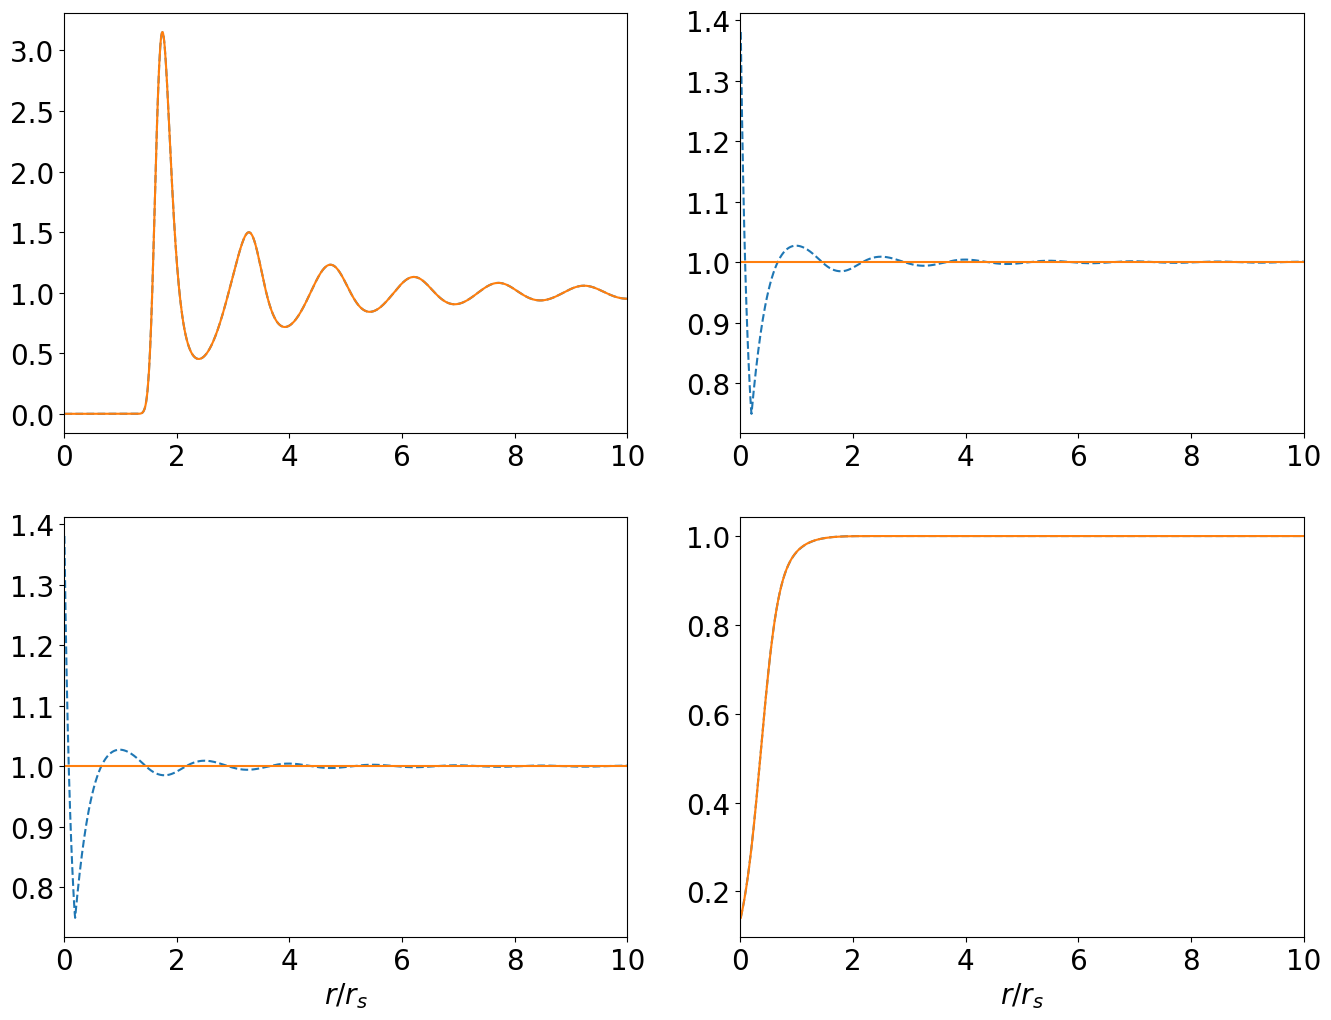

In [32]:
fig, axs = plt.subplots(2,2, figsize=(16,12))




for i in range(2):
        for j in range(2):
            
#             axs[i,j].plot(atom_list[0].k_array, atom_list[0].c_k_matrix[i,j])
#             axs[i,j].plot(atom_test.k_array, atom_test.c_k_matrix[i,j],'--')
            axs[i,j].plot(atom.r_array, atom.h_r_matrix[i,j]+1,'--',label='Al')
            axs[i,j].plot(atom_noe.r_array, atom_noe.h_r_matrix[i,j]+1,label='Al no e')
            
#             axs[i,j].plot(atom_list[0].k_array, atom_list[0].h_k_matrix[i,j])
#             axs[i,j].plot(atom_list[1].k_array, atom_list[1].h_k_matrix[i,j])
#             axs[i,j].plot(atom_test.k_array, atom_test.h_k_matrix[i,j],'--')

#             axs[i,j].plot(atom_list[0].r_array, atom_list[0].h_r_matrix[i,j])
#             axs[i,j].plot(atom_list[1].r_array, atom_list[1].h_r_matrix[i,j],'--')
#             axs[i,j].plot(atom_test.r_array, atom_test.h_r_matrix[i,j],'--')

            axs[i,j].tick_params(labelsize=20)
#             axs[i,j].set_xscale('log')
            axs[i,j].set_xlim(0,10)
            axs[i,j].tick_params(labelsize=20)
            axs[-1,j].set_xlabel(r"$r/r_s $",fontsize=20)
#             axs[i,j].set_yscale('symlog',linthresh=0.1)
#             axs[i,j].set_ylim(-10, 1e1)

#         axs[i,0].set_ylabel(r"$c(k)$",fontsize=20)

#  Pseudopotentials

In [89]:
Zstar/0.1

26.29

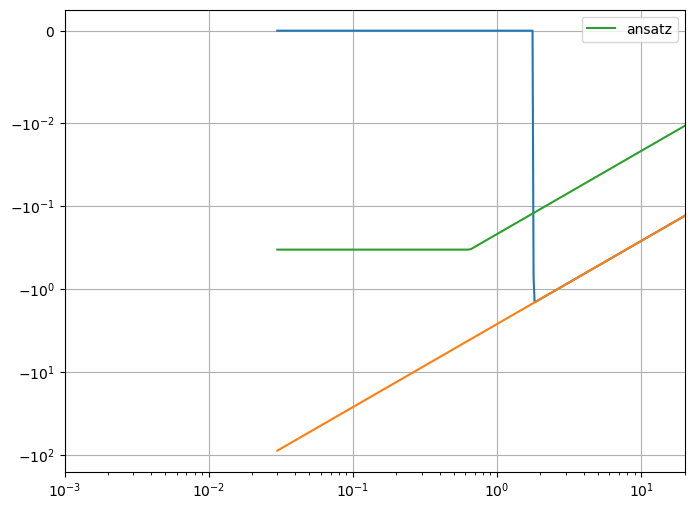

In [118]:
# vei_r_Ashcroft = Zstar*(-np.heaviside(atom.r_array - atomqsp.r_c, 0.5)/atom.r_array + 1/atom.r_array )/atomqsp.ri
# vei_r_Ashcroft = Zstar*(-np.heaviside(atom.r_array - atomqsp.r_c, 0.5)/atom.r_array  )/atomqsp.ri

# vei_free_ansatz = -atomqsp.Te_c*r_c*(np.heaviside(atom.r_array - r_c, 0.5)/atom.r_array + 1/r_c * np.heaviside(r_c - atom.r_array,0.5))
# vei_k_Ashcroft = atom.FT_r_2_k( vei_r_Ashcroft)
# fig, ax = plt.subplots(figsize=(8,6))

# # ax.plot(atom.k_array*atomqsp.ri, vei_k_Ashcroft)
# ax.plot(atom.r_array*atomqsp.ri, vei_r_Ashcroft)
# ax.plot(atom.r_array*atomqsp.ri, -Zstar/(atom.r_array*atomqsp.ri))
# ax.plot(atom.r_array*atomqsp.ri, vei_free_ansatz,label='ansatz')
# ax.set_xlim(1e-3,20)
# # ax.set_ylim(0,50)
# ax.set_xscale('log')
# ax.set_yscale('symlog',linthresh=1e-2)
# ax.legend()
# ax.grid()

#### Bound vs Free

In [66]:
ne_of_r_AU = atom.rho[1]*(atom.h_r_matrix[0,1]+1)/atomqsp.ri**3
ne_of_r_AU_p6 = atom_p6.rho[1]*(atom_p6.h_r_matrix[0,1]+1)/atomqsp.ri**3

/tmp/ipykernel_21041/3584328024.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0,6)


,r[AU],n[AU],nf[AU],nb[AU],n_ion[AU],(φ_e+φ_ions)[AU],φtotal[AU],δVxc/δρ[Au]
0,0.001000,141353.000000,0.000000e+00,141350.000000,0.000000,-52.813000,12946.800000,-38.659100
1,0.001110,120860.000000,1.712800e-143,120857.000000,0.000000,-52.769700,11661.200000,-36.700500
2,0.001232,103332.000000,1.126960e-128,103329.000000,0.000000,-52.711200,10502.800000,-34.840700
3,0.001367,88341.000000,2.505190e-115,88337.400000,0.000000,-52.638200,9458.950000,-33.074800
4,0.001517,75519.000000,2.629800e-103,75515.500000,0.000000,-52.550900,8518.370000,-31.397900
...,...,...,...,...,...,...,...,...
95,19.780100,0.023950,2.394390e-02,0.000006,0.008842,-0.223467,0.000428,-0.259901
96,21.950800,0.023949,2.394320e-02,0.000006,0.008842,-0.158478,0.000421,-0.259898
97,24.359800,0.023948,2.394240e-02,0.000006,0.008842,-0.099918,0.000414,-0.259896
98,27.033200,0.023944,2.393880e-02,0.000005,0.008842,-0.047173,0.000384,-0.259883


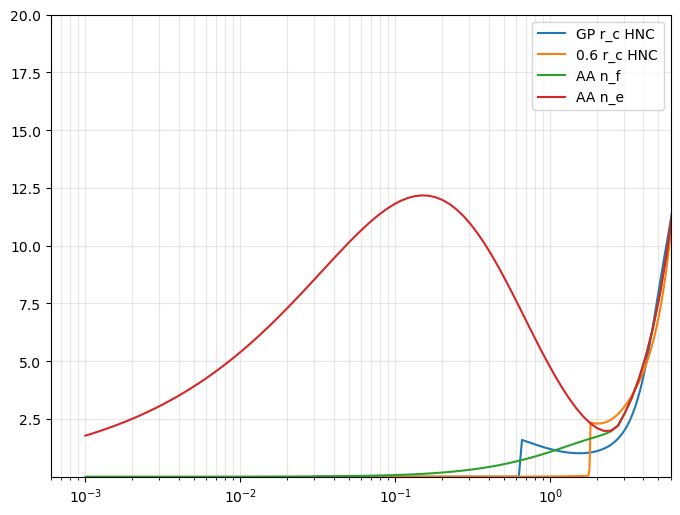

In [71]:
fig, ax = plt.subplots(figsize=(8,6))
AA_data = read_csv('/home/zach/plasma/atomic_forces/average_atom/data/converged/Al_NPA_TFD_R3.0e+01_rs3.0e+00_T1.0e+00eV/Al_NPA_TFD_R3.0e+01_rs3.0e+00_T1.0e+00eV_Zstar2.7.dat', delim_whitespace=True,header=2)

geom_factor = 4*π*atom.r_array**2*atomqsp.ri**2
ax.plot(atom.r_array*atomqsp.ri, ne_of_r_AU*geom_factor, label='GP r_c HNC')
ax.plot(atom_p6.r_array*atomqsp.ri, ne_of_r_AU_p6*geom_factor, label='0.6 r_c HNC')
ax.plot(AA_data['r[AU]'], AA_data['nf[AU]']*4*π*AA_data['r[AU]']**2, label="AA n_f")
# ax.plot(AA_data['r[AU]'], AA_data['nb[AU]']*4*π*AA_data['r[AU]']**2)
ax.plot(AA_data['r[AU]'], (AA_data['nb[AU]']+AA_data['nf[AU]'])*4*π*AA_data['r[AU]']**2, label='AA n_e')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(which='both', alpha=0.3)
ax.set_ylim(1e-4,2e1)
ax.set_xlim(0,6)
ax.legend()
AA_data

## Total Charge and Neutrality

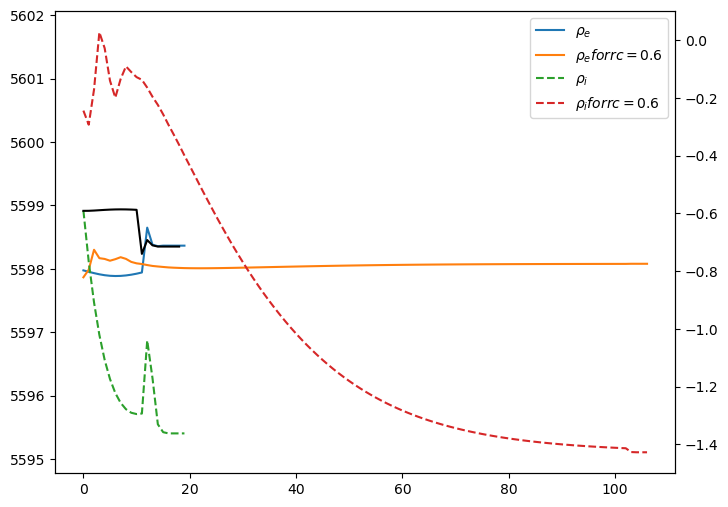

In [112]:
fig, ax = plt.subplots(1,1, figsize=(8,6))


ρ_e = [ atomqsp.ri**3*atom.rho[1]*np.sum(((h_r_matrix[0,1]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom.h_r_matrix_list]
ρ_e_p6 = [ atomqsp.ri**3*atom_p6.rho[1]*np.sum(((h_r_matrix[0,1]+1)*atom_p6.r_array**2)*atom_p6.del_r) for h_r_matrix in atom_p6.h_r_matrix_list]
ρ_i = [ Zstar+ Zstar*atomqsp.ri**3*atom.rho[0]*np.sum(((h_r_matrix[0,0]+1)*atom.r_array**2)*atom.del_r) for h_r_matrix in atom.h_r_matrix_list]
ρ_i_p6 = [ Zstar+ Zstar*atomqsp_p6.ri**3*atom_p6.rho[0]*np.sum(((h_r_matrix[0,0]+1)*atom_p6.r_array**2)*atom_p6.del_r) for h_r_matrix in atom_p6.h_r_matrix_list]

# ax.plot(ρ_e ,label=r'$\rho_e$')#, color=color)
# ax.plot(ρ_i,  '--', label=r'$\rho_i$')#,color=color)
ax.plot(ρ_e ,label=r'$\rho_e$')#, color=color)
ax.plot(ρ_e_p6 ,label=r'$\rho_e for rc=0.6$')#, color=color)
ax.plot(ρ_i,  '--', label=r'$\rho_i$')#,color=color)
ax.plot(ρ_i_p6,  '--', label=r'$\rho_i for rc=0.6$')#,color=color)
ax2 = ax.twinx()
ax2.plot(atom.u_ex_list,'-k')

# ax.set_ylim(8.75,9.2)
ax2.set_ylim(-1.5,.1)
ax.legend()

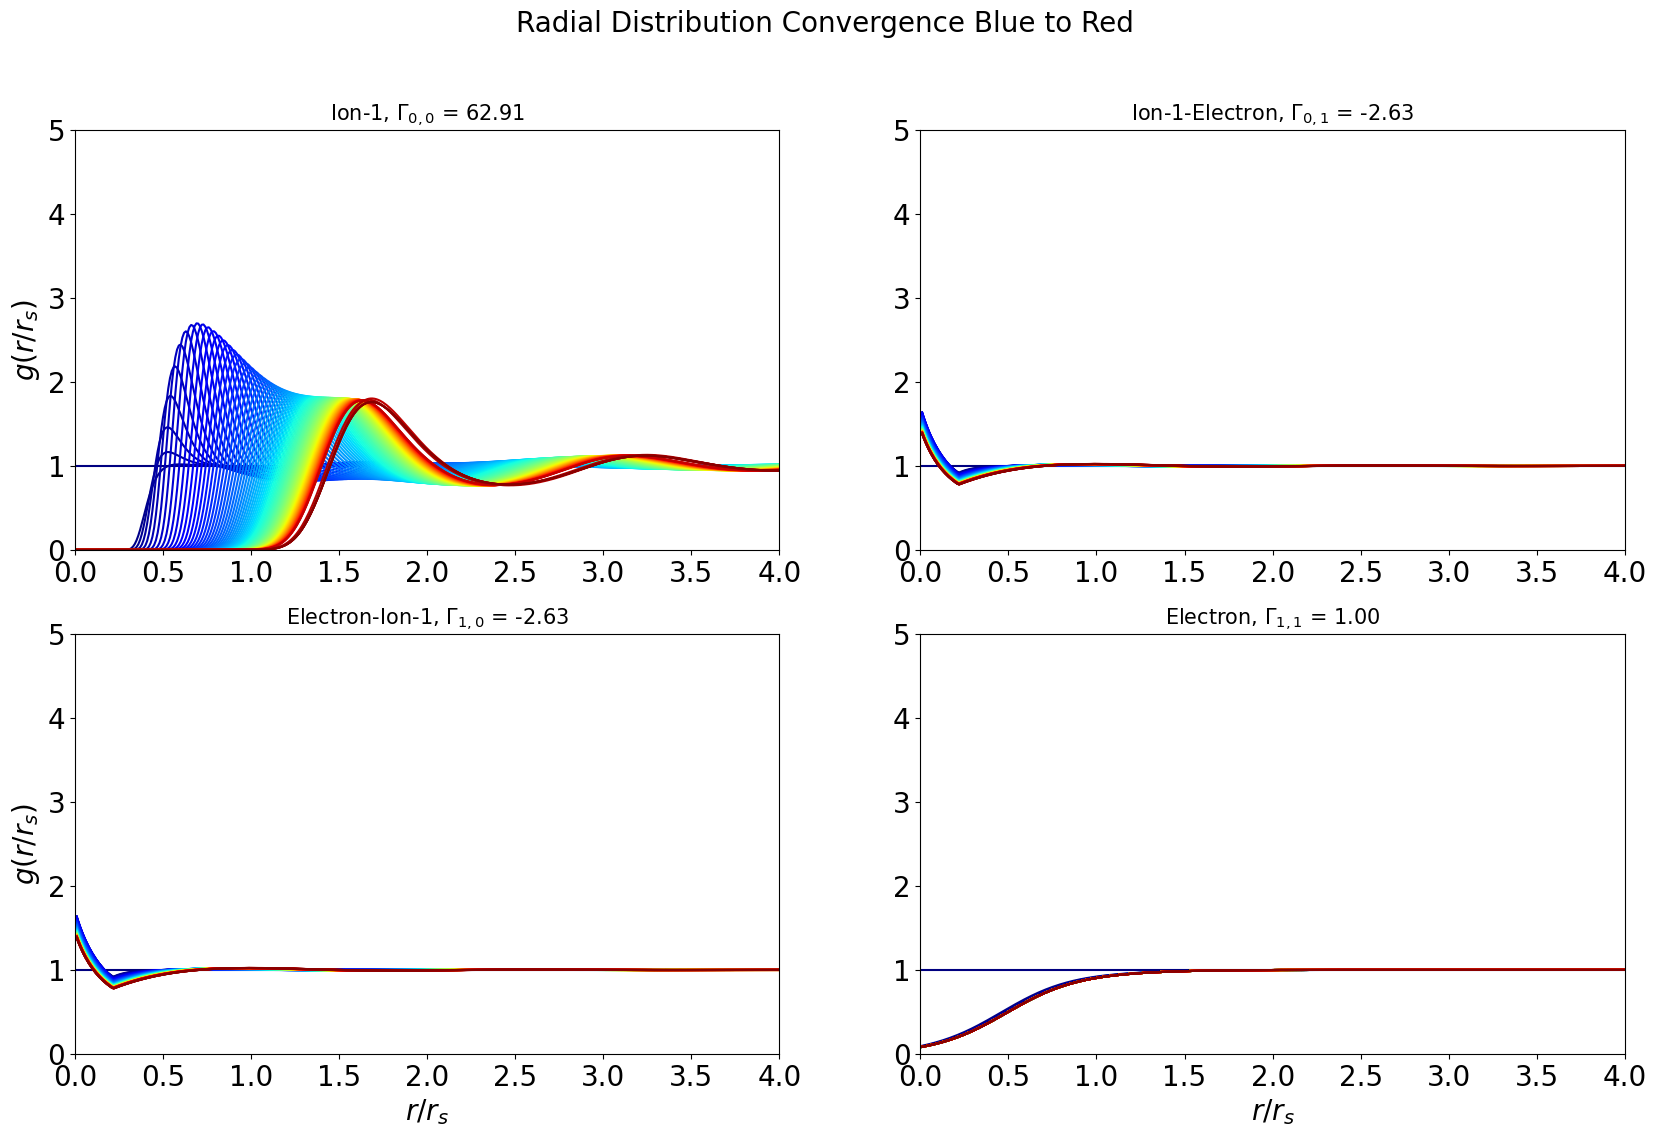

In [11]:
atom.plot_species_convergence_g(n_slices= int(len(atom.h_r_matrix_list)/1)  )

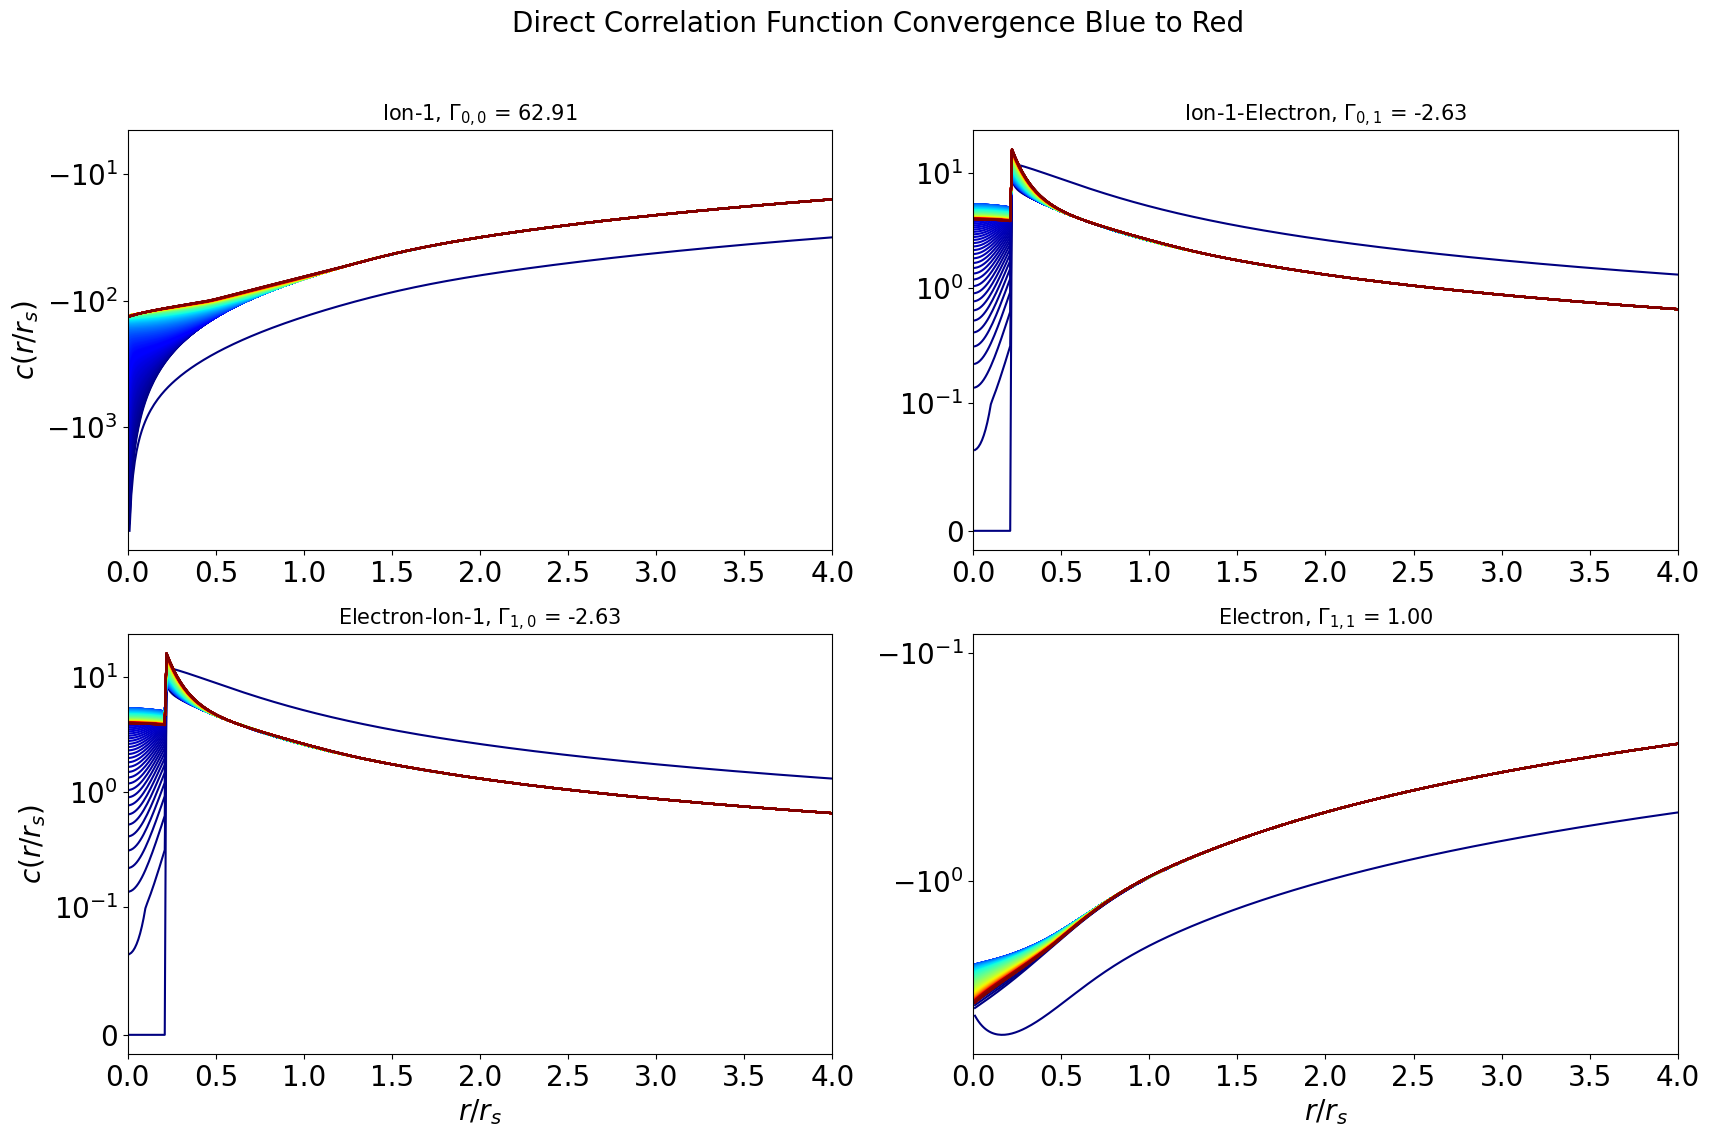

In [11]:
atom.plot_species_convergence_c(n_slices= int(len(atom.h_r_matrix_list)/1)  )

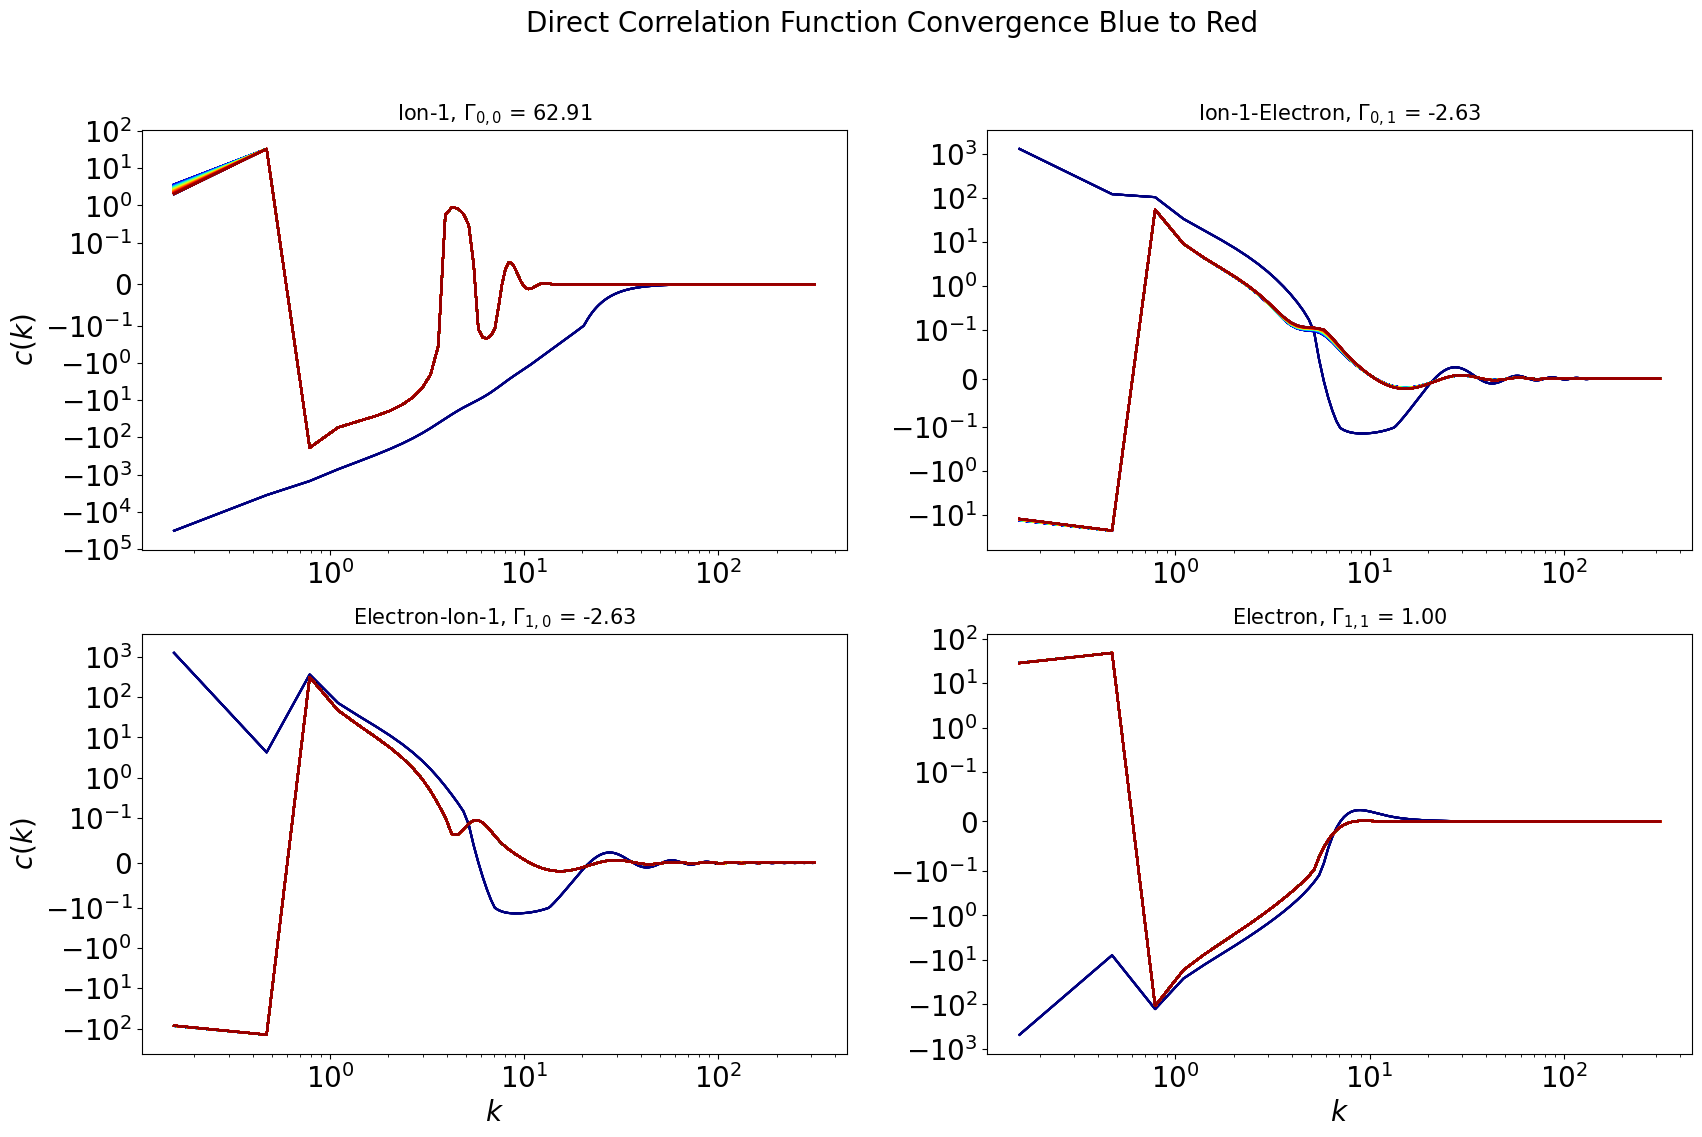

In [17]:
atom_normal.plot_species_convergence_ck(n_slices= int(len(atom.h_r_matrix_list)/1)  )

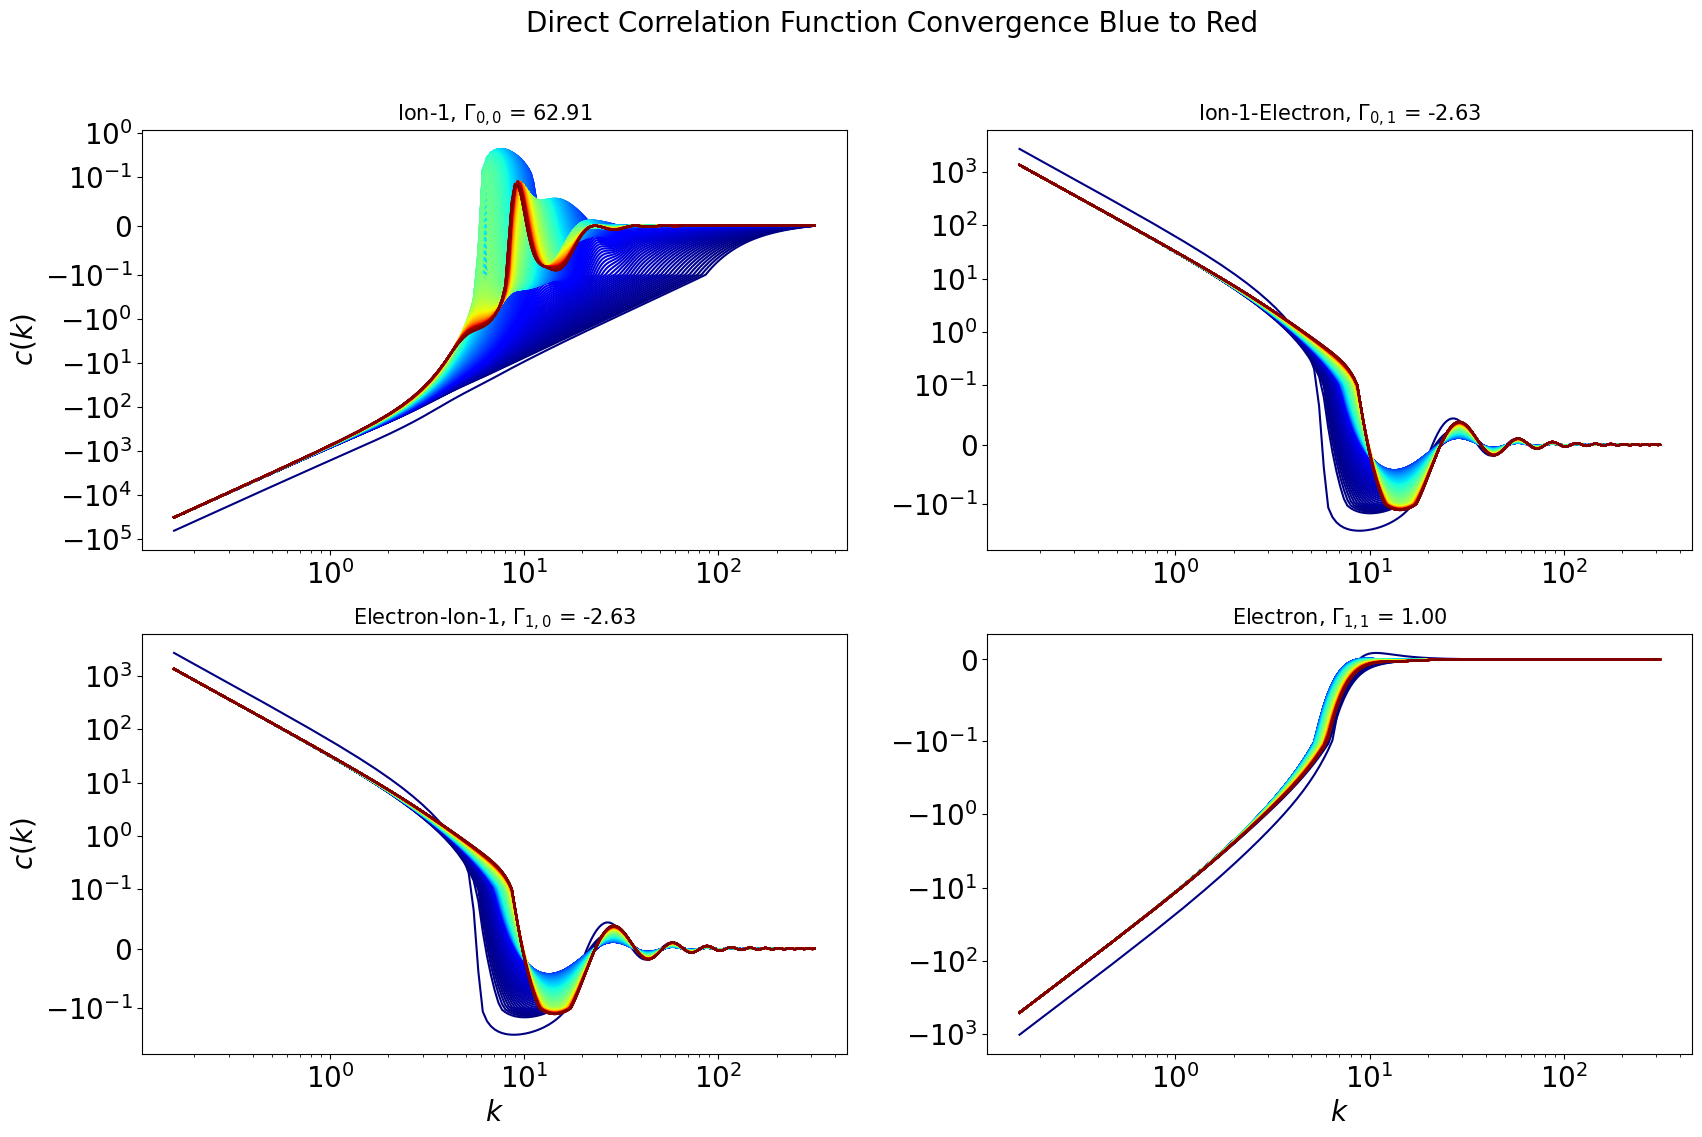

In [9]:
atom.plot_species_convergence_ck(n_slices= int(len(atom.h_r_matrix_list)/1)  )

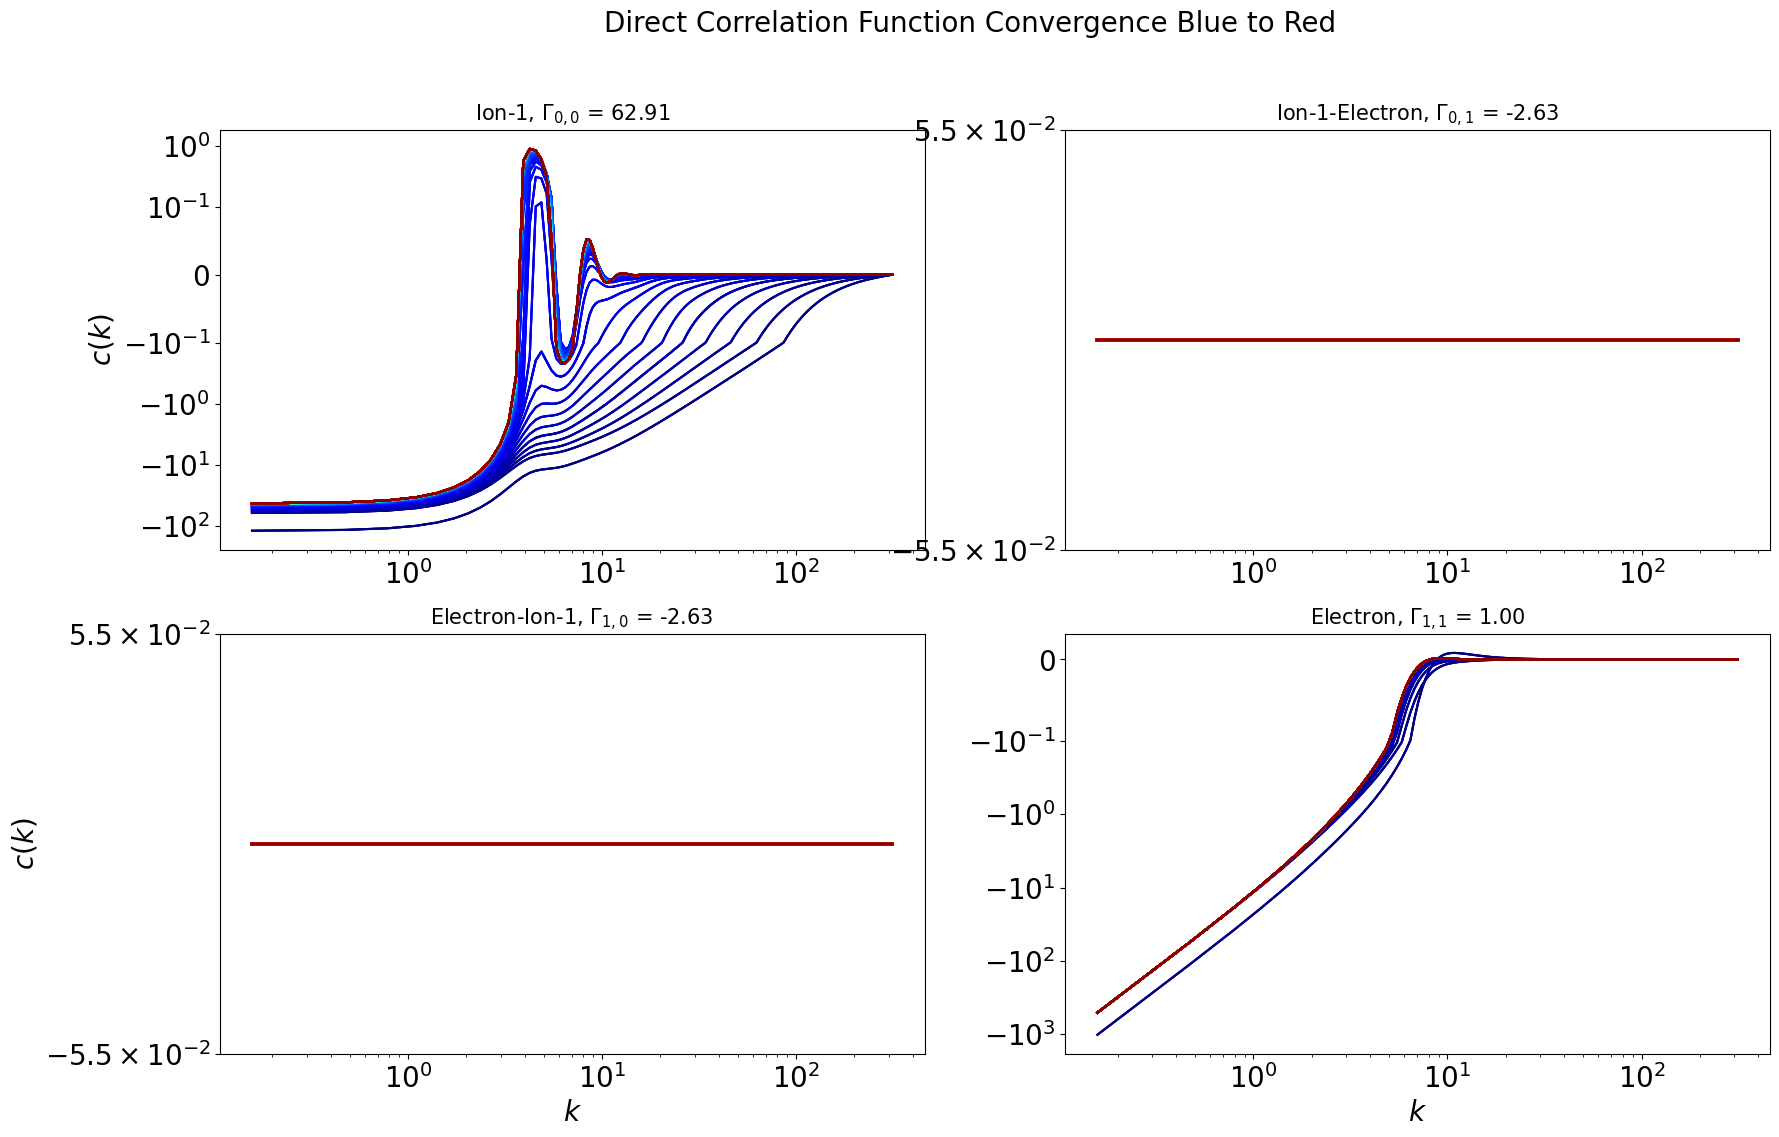

In [8]:
atom_nocoupling.plot_species_convergence_ck(n_slices= int(len(atom.h_r_matrix_list)/1)  )

In [ ]:
atom.plot_species_convergence_g(n_slices= int(len(atom.h_r_matrix_list)/1)  )
atom.plot_species_convergence_c(n_slices= int(len(atom.h_r_matrix_list)/1)  )

In [ ]:
Al_file = "/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt"  # 1 eV
Al_file = '/home/zach/plasma/datasets/RDFs/Al_0.5eV_rs3_KS-MD.txt' # 0.5 eV
Al_data = read_csv(Al_file,header=0, names=['r','g'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Al TCCW Case, 1 eV, rs=3', fontsize=20, y=0.95)

ax.plot(Al_data['r'], Al_data['g'],'ro', label = 'VASP' )
# ax.plot(atom.r_array, atom_one_species.h_r_matrix[0,0] + 1, label='No electrons')
ax.plot(atom.r_array, atom.h_r_matrix[0,0] + 1, label='SVT Ashcroft Empy Yukawa Bridge')
# ax.plot(atom.r_array, atomSVT.h_r_matrix[0,0] + 1, label='SVT Ashcroft')
# ax.plot(atom.r_array, atomSVT_Yuk.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + Yukawa Bridge')
# ax.plot(atom.r_array, atomSVT_OCP.h_r_matrix[0,0] + 1,'--', label='SVT Ashcroft + OCP Bridge')

ax.set_ylabel(r'$g(r)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.5,4)
ax.legend(fontsize=15)


# βu_eff matching

In [6]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [7]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [8]:
atom.invert_HNC_OZ([1])
fit1 = βu_fit(yukawa_plus, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ(),2 , 1])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

yukawa_plus error: 2.220e+01 


/tmp/ipykernel_30014/2646033414.py:19: RuntimeWarning: overflow encountered in exp
  return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)
/tmp/ipykernel_30014/2646033414.py:19: RuntimeWarning: invalid value encountered in cos
  return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)
/tmp/ipykernel_30014/2646033414.py:19: RuntimeWarning: overflow encountered in multiply
  return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)


In [9]:
luke_r

1      0.006321
2      0.014692
3      0.023062
4      0.031433
5      0.039804
         ...   
601    5.023547
602    5.031908
603    5.040268
604    5.048628
605    5.056988
Name: r [A], Length: 605, dtype: float64

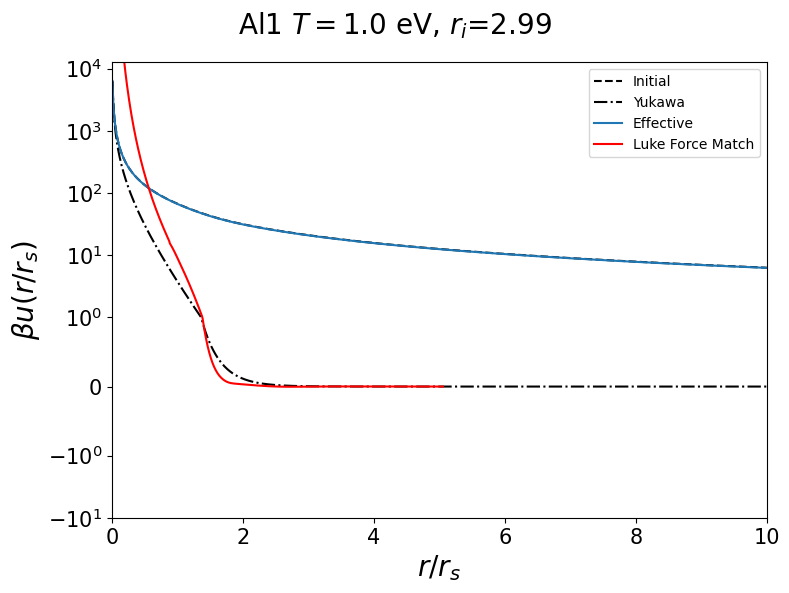

In [10]:
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)


yukawa_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array * np.exp(-atom.r_array*atomqsp.get_κ())[np.newaxis,np.newaxis,:] ) [:-1,:-1]
coulomb_matrix = (atom.Gamma[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(atom.r_array, yukawa_matrix[0,0],'k-.', label="Yukawa")

ax.plot(atom.r_array, atom.βueff_r_matrix[0,0],color=colors[0], label='Effective')    
ax.plot(luke_r, luke_βV,'r-', label='Luke Force Match')

ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(0, R_max)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)
fig.tight_layout()